In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

#### PART A: Data Preparation & Cleaning

In [25]:
def load_data():
    # Load the datasets provided in the assignment
    sentiment_df = pd.read_csv(r'C:\Users\Amaan Siddiqui\OneDrive\New folder\Desktop\VS code\Market-Sentiment--Fear-Greed-\Dataset\fear_greed_index.csv')
    trading_df = pd.read_csv(r'C:\Users\Amaan Siddiqui\OneDrive\New folder\Desktop\VS code\Market-Sentiment--Fear-Greed-\Dataset\historical_data.csv')

    # Initial Profiling (Part A-1)
    for name, df in [("Sentiment", sentiment_df), ("Trading", trading_df)]:
        print(f"--- {name} Dataset Profile ---")
        print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
        print(f"Missing Values:\n{df.isnull().sum()}")
        print(f"Duplicates: {df.duplicated().sum()}\n")
    
    return sentiment_df, trading_df

sentiment_df, trading_df = load_data()

--- Sentiment Dataset Profile ---
Rows: 2644, Columns: 4
Missing Values:
timestamp         0
value             0
classification    0
date              0
dtype: int64
Duplicates: 0

--- Trading Dataset Profile ---
Rows: 211224, Columns: 16
Missing Values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Duplicates: 0



In [26]:
# Convert sentiment dates
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

# Convert Hyperliquid trading timestamps (Format: DD-MM-YYYY HH:MM)
trading_df['date'] = pd.to_datetime(trading_df['Timestamp IST'], format='%d-%m-%Y %H:%M').dt.date

# Align datasets by date
merged_df = pd.merge(trading_df, sentiment_df[['date', 'classification', 'value']], on='date', how='inner')
print(f"Aligned Data Points: {len(merged_df)}")

Aligned Data Points: 211218


### PART B: Behavioral Feature Engineering

In [31]:
# 1. Define Side Bias (1 for BUY, -1 for SELL)
merged_df['side_bias'] = merged_df['Side'].map({'BUY': 1, 'SELL': -1})

# 2. Aggregate metrics per Account per Day
# include the sentiment "value" so it can be used as a feature later
daily_behavior = merged_df.groupby(['Account', 'date', 'classification']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    total_volume=('Size USD', 'sum'),
    trade_count=('Trade ID', 'count'),
    avg_bias=('side_bias', 'mean'),
    winning_trades=('Closed PnL', lambda x: (x > 0).sum()),
    value=('value', 'first')
).reset_index()

# 3. Calculate Win Rate
daily_behavior['win_rate'] = daily_behavior['winning_trades'] / daily_behavior['trade_count']

In [32]:
# Use the 75th percentile of volume to identify 'Whales'
volume_threshold = daily_behavior['total_volume'].quantile(0.75)

def categorize_trader(volume):
    if volume > volume_threshold:
        return 'Whale'
    return 'Retail'

daily_behavior['trader_segment'] = daily_behavior['total_volume'].apply(categorize_trader)

### Part C : Plotting Graphs

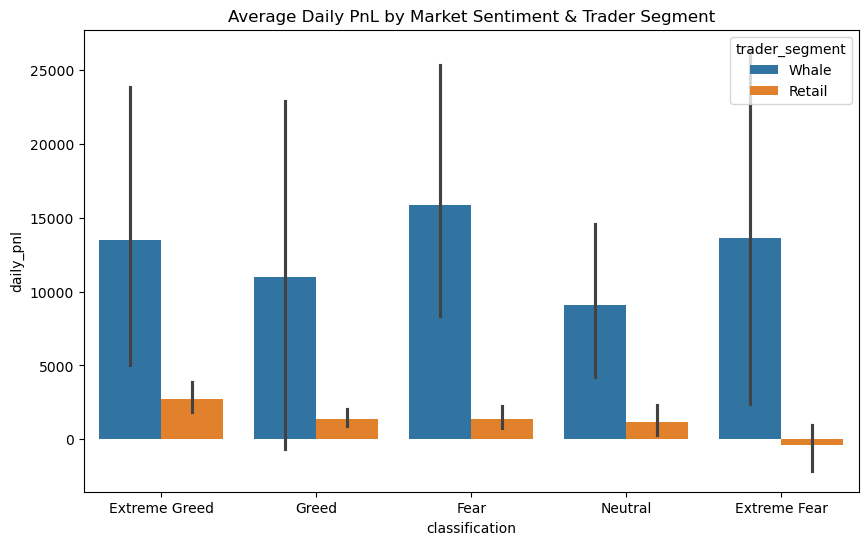

In [33]:
# Group insights by sentiment classification
sentiment_analysis = daily_behavior.groupby('classification').agg({
    'daily_pnl': 'mean',
    'win_rate': 'mean',
    'trade_count': 'mean'
}).reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])

# Visualization: Profitability vs. Sentiment
plt.figure(figsize=(10, 6))
sns.barplot(data=daily_behavior, x='classification', y='daily_pnl', hue='trader_segment')
plt.title('Average Daily PnL by Market Sentiment & Trader Segment')
plt.show()

###  PART D: Predictions

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create target: Is next day PnL positive?
daily_behavior = daily_behavior.sort_values(['Account', 'date'])
daily_behavior['next_day_profitable'] = (daily_behavior.groupby('Account')['daily_pnl'].shift(-1) > 0).astype(int)

# Drop last entries for each account (no 'next day' data)
model_data = daily_behavior.dropna()

# Features and Target
features = ['value', 'total_volume', 'trade_count', 'avg_bias']
X = model_data[features]
y = model_data['next_day_profitable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

# Evaluation
y_pred = rf_model.predict(X_test)
print(f"Next-Day Profitability Prediction Accuracy: {accuracy_score(y_test, y_pred):.2%}")

Next-Day Profitability Prediction Accuracy: 62.61%
